# Base Model - S5_v0

# Target:

1. Get the set-up right
2. Set Transforms
3. Set Data Loader
4. Set Basic Working Code
5. Set Basic Training  & Test Loop

# Results:

1. Parameters: 292164 
2. Best Training Accuracy: 99.73
3. Best Test Accuracy: 99.08

# Analysis:

1. Model is heavy as capacity is huge
2. Model is over-fitting

# Set the Batteries

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary
from torchvision import transforms
from torchvision.datasets import MNIST
import warnings
import matplotlib.pyplot as plt


In [ ]:
warnings.filterwarnings('ignore')

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 

Here is the list of all the transformations which come pre-built with PyTorch

1. Compose
2. ToTensor
3. ToPILImage
4. Normalize
5. Resize
6. Scale
7. CenterCrop
8. Pad
9. Lambda
10. RandomApply
11. RandomChoice
12. RandomOrder
13. RandomCrop
14. RandomHorizontalFlip
15. RandomVerticalFlip
16. RandomResizedCrop
17. RandomSizedCrop
18. FiveCrop
19. TenCrop
20. LinearTransformation
21. ColorJitter
22. RandomRotation
23. RandomAffine
24. Grayscale
25. RandomGrayscale
26. RandomPerspective
27. RandomErasing

You can read more about them [here](https://pytorch.org/docs/stable/_modules/torchvision/transforms/transforms.html)

In [ ]:
train_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

In [ ]:
train = MNIST('./data', transform=train_transforms, download=True,train=True)
test = MNIST('./data', transform=test_transforms, download=True, train=False)

# Data Loader

In [ ]:
SEED = 1
batch_size = 128
num_workers = 4



cuda = torch.cuda.is_available()
print(f"Cuda available? {cuda}")

torch.manual_seed(SEED)# For reproducibility

if cuda:
  torch.cuda.manual_seed(SEED)# For reproducibility

# dataloader arguments - something you'll fetch these from cmdprmt
data_loader_args = dict(shuffle=True, num_workers=num_workers, pin_memory=True, batch_size=batch_size) if cuda else dict(shuffle=True,batch_size=batch_size)

train_data_loader = torch.utils.data.DataLoader(train, **data_loader_args)

test_data_loader = torch.utils.data.DataLoader(test, **data_loader_args)

Cuda available? True


# Data Statistics

In [ ]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0002)
 - std: tensor(1.0000)
 - var: tensor(1.0001)


In [ ]:
data_iter = iter(train_data_loader)
images, labels = data_iter.next()
print(images.shape)
print(labels.shape)

torch.Size([128, 1, 28, 28])
torch.Size([128])


#### Data Visualization

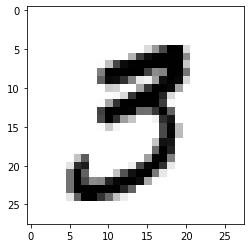

In [ ]:
plt.imshow(images[1].squeeze(), cmap='gray_r')
plt.show()

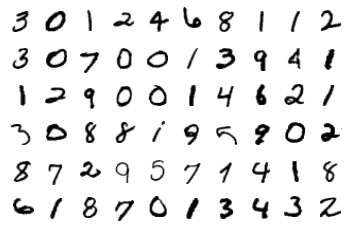

In [ ]:
figure = plt.figure()
num_images = 60

for i in range(1, num_images+1):
  plt.subplot(6,10,i)
  plt.axis("off")
  plt.imshow(images[i].numpy().squeeze(), cmap='gray_r')

In [ ]:
# simple transform to get actual mean and std before normalizing
simple_transforms = transforms.Compose([
                                       transforms.ToTensor(),
                                       ])
exp = MNIST('./data', train=True, download=True, transform=simple_transforms)
exp_data = exp.train_data
exp_data = exp.transform(exp_data.numpy())

print('[Train]')
print(' - Numpy Shape:', exp.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', exp.train_data.size())
print(' - min:', torch.min(exp_data))
print(' - max:', torch.max(exp_data))
print(' - mean:', torch.mean(exp_data))
print(' - std:', torch.std(exp_data))
print(' - var:', torch.var(exp_data))

[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


# Model Building

In [ ]:
def get_receptive_field(r_in, k, j_in):
  return r_in + (k-1)*j_in

In [ ]:
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32,kernel_size=3,padding=1,bias=False)   #RF - 3, Output_shape=28
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=32,kernel_size=3,padding=1,bias=False)  #RF - 5, Output_shape=28
    self.pool1 = nn.MaxPool2d(kernel_size=2,stride=2)                                           #RF - 6, Output_shape=14
    self.conv3 = nn.Conv2d(in_channels=32, out_channels=64,kernel_size=3,padding=1,bias=False)  #RF - 10, Output_shape=14
    self.conv4 = nn.Conv2d(in_channels=64, out_channels=64,kernel_size=3,padding=1,bias=False)  #RF - 14, Output_shape=14
    self.pool2 = nn.MaxPool2d(kernel_size=2,stride=2)                                           #RF - 16, Output_shape=7
    self.conv5 = nn.Conv2d(in_channels=64, out_channels=128,kernel_size=3,padding=1,bias=False)  #RF - 24, Output_shape=7
    self.conv6 = nn.Conv2d(in_channels=128, out_channels=128,kernel_size=3,padding=1,bias=False)  #RF - 32, Output_shape=7
    self.conv7 = nn.Conv2d(in_channels=128, out_channels=10,kernel_size=1,bias=False)  #RF - 40, Output_shape=7
    self.conv8 = nn.Conv2d(in_channels=10, out_channels=10,kernel_size=7,bias=False)  #RF - 48, Output_shape=1
  def forward(self,x):
    x = self.pool1(F.relu(self.conv2(F.relu(self.conv1(x)))))
    x = self.pool2(F.relu(self.conv4(F.relu(self.conv3(x)))))
    x = F.relu(self.conv7(F.relu(self.conv6(F.relu(self.conv5(x))))))
    x = self.conv8(x)
    x = x.view(-1,10)
    return F.log_softmax(x, dim=-1)

# Model parameters

In [ ]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1,28,28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
            Conv2d-2           [-1, 32, 28, 28]           9,216
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 64, 14, 14]          18,432
            Conv2d-5           [-1, 64, 14, 14]          36,864
         MaxPool2d-6             [-1, 64, 7, 7]               0
            Conv2d-7            [-1, 128, 7, 7]          73,728
            Conv2d-8            [-1, 128, 7, 7]         147,456
            Conv2d-9             [-1, 10, 7, 7]           1,280
           Conv2d-10             [-1, 10, 1, 1]           4,900
Total params: 292,164
Trainable params: 292,164
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.75
Params size (MB): 1.11
Estima

# Training and Testing

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

# Let's train and test the model

In [ ]:
model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 14
for epoch in range(EPOCHS):
    print(f" ***** EPOCH:{epoch} ***** ")
    train(model, device, train_data_loader, optimizer, epoch)
    test(model, device, test_data_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

 ***** EPOCH:0 ***** 


Loss=0.12835855782032013 Batch_id=468 Accuracy=67.06: 100%|██████████| 469/469 [00:10<00:00, 44.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1142, Accuracy: 9642/10000 (96.42%)

 ***** EPOCH:1 ***** 


Loss=0.12424444407224655 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:10<00:00, 44.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0599, Accuracy: 9816/10000 (98.16%)

 ***** EPOCH:2 ***** 


Loss=0.024555064737796783 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:10<00:00, 44.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9857/10000 (98.57%)

 ***** EPOCH:3 ***** 


Loss=0.027536317706108093 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:10<00:00, 45.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0393, Accuracy: 9883/10000 (98.83%)

 ***** EPOCH:4 ***** 


Loss=0.04170045629143715 Batch_id=468 Accuracy=98.85: 100%|██████████| 469/469 [00:10<00:00, 45.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9884/10000 (98.84%)

 ***** EPOCH:5 ***** 


Loss=0.013777335174381733 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:10<00:00, 45.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9898/10000 (98.98%)

 ***** EPOCH:6 ***** 


Loss=0.03118482045829296 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:10<00:00, 46.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9899/10000 (98.99%)

 ***** EPOCH:7 ***** 


Loss=0.024587107822299004 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:10<00:00, 44.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9901/10000 (99.01%)

 ***** EPOCH:8 ***** 


Loss=0.015131550841033459 Batch_id=468 Accuracy=99.43: 100%|██████████| 469/469 [00:10<00:00, 43.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9903/10000 (99.03%)

 ***** EPOCH:9 ***** 


Loss=0.03819703683257103 Batch_id=468 Accuracy=99.55: 100%|██████████| 469/469 [00:10<00:00, 43.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9895/10000 (98.95%)

 ***** EPOCH:10 ***** 


Loss=0.01556064561009407 Batch_id=468 Accuracy=99.58: 100%|██████████| 469/469 [00:10<00:00, 46.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0318, Accuracy: 9901/10000 (99.01%)

 ***** EPOCH:11 ***** 


Loss=0.005259449128061533 Batch_id=468 Accuracy=99.63: 100%|██████████| 469/469 [00:10<00:00, 44.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0369, Accuracy: 9897/10000 (98.97%)

 ***** EPOCH:12 ***** 


Loss=0.006665520835667849 Batch_id=468 Accuracy=99.62: 100%|██████████| 469/469 [00:10<00:00, 43.82it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0330, Accuracy: 9908/10000 (99.08%)

 ***** EPOCH:13 ***** 


Loss=0.006740722339600325 Batch_id=468 Accuracy=99.73: 100%|██████████| 469/469 [00:10<00:00, 44.37it/s]



Test set: Average loss: 0.0416, Accuracy: 9895/10000 (98.95%)



# Model results analysis

Text(0.5, 1.0, 'Test Accuracy')

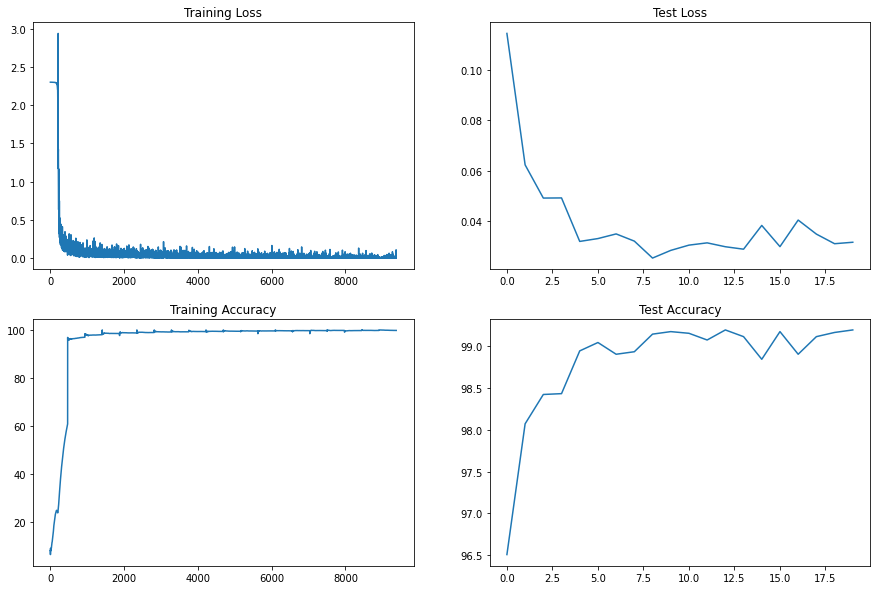

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")